<a href="https://colab.research.google.com/github/VijayavaniBandi/RL_p1/blob/main/RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import time
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive, widgets
from IPython.display import display, clear_output

In [65]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [66]:
IMAGES_DIR = "/content/drive/MyDrive/Assignment1/images"

In [67]:
MAX_TIMESTEP = 10
MAZE_WIDTH = 4
MAZE_LENGTH = 4
NUM_ACTIONS = 4
NUM_STATES = MAZE_WIDTH * MAZE_LENGTH

In [68]:
START_POS = np.asarray([3, 0])
FINISH_POS = np.asarray([0, 3])
GOLD_POS = np.asarray([0, 0])
SILVER_POS = np.asarray([3, 3])
OBSTACLE_POS = np.asarray([[2, 0], [1, 2], [1, 3], [3, 2]])

In [69]:
MAZE = np.zeros((MAZE_WIDTH, MAZE_LENGTH))
MAZE[tuple(START_POS)] = 2
MAZE[tuple(FINISH_POS)] = 3
MAZE[tuple(SILVER_POS)] = 4
MAZE[tuple(GOLD_POS)] = 5
for i in range(len(OBSTACLE_POS)):
    MAZE[tuple(OBSTACLE_POS[i])] = -1

In [70]:
IMAGE_DICT = {-1: '/content/obstacle.png', 0: '/content/path.png', 1: '/content/agent.png', 2: '/content/start.png',
              3: '/content/finish.png', 4: '/content/silver.png', 5: '/content/gold.png', 
              9: '/content/agent_obstacle.png', 12: '/content/agent_start.png', 
              13: '/content/agent_finish.png', 14: '/content/agent_silver.png', 
              15: '/content/agent_gold.png'}

In [71]:
def img_reshape(img):
    img = Image.open(os.path.join(IMAGES_DIR, img)).convert('RGB')
    img = img.resize((200, 200))
    img = np.asarray(img)
    return img


def maze_generator(maze):
    img_arr = []
    for state in maze:
        img_arr.append(img_reshape(f"{IMAGE_DICT[state]}"))
    array = np.array(img_arr)
    index, height, width, channels = array.shape
    img_grid = array.reshape(MAZE_WIDTH, MAZE_LENGTH, height, width, channels) \
                .swapaxes(1, 2).reshape(height * MAZE_WIDTH, 
                                        width * MAZE_LENGTH, channels)
    return img_grid

In [72]:
class MazeDeterministicEnv(gym.Env):
    """
    Creating the following custom maze as environment.
    [5, 0, 0, 3,
    0, 0, -1, -1,
    -1, 0, 0, 0,
    2, 0, -1, 4]

    ### Description
    -> 0 represents a valid position for an agent
    -> -1 represents an obstacle
    -> 2 represents the start point
    -> 3 represents the finish point
    -> 4 represents silver
    -> 5 represents gold

    ### Action Space
    -> 0 represents moving up (North)
    -> 1 represents moving right (East)
    -> 2 represents moving down (South)
    -> 3 represents moving left (West)

    ### Reward
    -> 10 for reaching the finish line
    -> 4 for collecting gold
    -> 2 for collecting silver
    -> -5 for running into an obstacle
    -> -0.5 for any other step

    ### Motivation for the values
    -> The agent should be able to reach finish line, maximising the points it
      earns. With the given values, Collecting silver is not beneficial at all.
    """ 
    metadata = {"render_modes": ['human']}

    def __init__(self, env_type=None):
        self.observation_space = spaces.Discrete(NUM_STATES)
        self.action_space = spaces.Discrete(NUM_ACTIONS)

        self.maze = MAZE.copy()
        self.timestep = 0
        self.gold_qty = 1
        self.silver_qty = 1
        self.agent_pos = START_POS.copy()

    def reset(self):
        self.timestep = 0
        self.agent_pos = START_POS.copy()
        self.gold_qty = 1
        self.silver_qty = 1
        return self._get_state(self.agent_pos)

    def step(self, action):
        assert self.action_space.contains(action)
        self.timestep += 1

        if action == 0 and self.agent_pos[0] > 0:
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[1] < 3:
            self.agent_pos[1] += 1
        elif action == 2 and self.agent_pos[0] < 3:
            self.agent_pos[0] += 1
        elif action == 3 and self.agent_pos[1] > 0:
            self.agent_pos[1] -= 1

        self.maze = MAZE.copy()
        done = False
        if np.array_equal(self.agent_pos, FINISH_POS):
            reward = 10
            done = True
        elif any(np.array_equal(OBSTACLE_POS[i], self.agent_pos) for i in 
                 range(len(OBSTACLE_POS))):
            reward = -10
        elif np.array_equal(self.agent_pos, SILVER_POS) and self.silver_qty > 0:
            reward = 2
            self.silver_qty = 0
        elif np.array_equal(self.agent_pos, GOLD_POS) and self.gold_qty > 0:
            reward = 4
            self.gold_qty = 0
        else:
            reward = -0.5

        if self.timestep >= MAX_TIMESTEP:
            done = True

        info = {}
        return self._get_state(self.agent_pos), reward, done, info

    def _get_state(self, agent_pos):
        return agent_pos[0] * MAZE_LENGTH + agent_pos[1]

    def render(self):
        if self.gold_qty == 0:
            self.maze[tuple(GOLD_POS)] = 0
        if self.silver_qty == 0:
            self.maze[tuple(SILVER_POS)] = 0
        self.maze[tuple(self.agent_pos)] += 10
        if self.maze[tuple(self.agent_pos)] % 10 == 0:
            self.maze[tuple(self.agent_pos)] = 1
        fig = plt.figure(figsize=(8., 8.))
        plt.imshow(maze_generator(self.maze.ravel()))

In [73]:
class MazeStochasticEnv(gym.Env):
    """
    Creating the following custom maze as environment.
    [5, 0, 0, 3,
    0, 0, -1, -1,
    -1, 0, 0, 0,
    2, 0, -1, 4]

    ### Description
    -> 0 represents a valid position for an agent
    -> -1 represents an obstacle
    -> 2 represents the start point
    -> 3 represents the finish point
    -> 4 represents silver
    -> 5 represents gold

    ### Action Space
    -> 0 represents moving up (North)
    -> 1 represents moving right (East)
    -> 2 represents moving down (South)
    -> 3 represents moving left (West)

    ### Reward
    -> 10 for reaching the finish line
    -> 4 for collecting gold
    -> 2 for collecting silver
    -> -5 for running into an obstacle
    -> -0.5 for any other step

    ### Motivation for the values
    -> The agent should be able to reach finish line, maximising the points it
      earns. With the given values, Collecting silver is not beneficial at all.
    """ 
    metadata = {"render_modes": ['human']}

    def __init__(self, env_type=None):
        self.observation_space = spaces.Discrete(NUM_STATES)
        self.action_space = spaces.Discrete(NUM_ACTIONS)

        self.maze = MAZE.copy()
        self.timestep = 0
        self.gold_qty = 1
        self.silver_qty = 1
        self.agent_pos = START_POS.copy()

    def reset(self):
        self.timestep = 0
        self.agent_pos = START_POS.copy()
        self.gold_qty = 1
        self.silver_qty = 1
        return self._get_state(self.agent_pos)

    def step(self, action):
        assert self.action_space.contains(action)
        self.timestep += 1

        alternate_action = [act for act in range(self.action_space.n) 
                              if act != action]
        action = action if np.random.uniform() > 0.25 \
                          else np.random.choice(alternate_action)

        if action == 0 and self.agent_pos[0] > 0:
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[1] < 3:
            self.agent_pos[1] += 1
        elif action == 2 and self.agent_pos[0] < 3:
            self.agent_pos[0] += 1
        elif action == 3 and self.agent_pos[1] > 0:
            self.agent_pos[1] -= 1

        self.maze = MAZE.copy()
        done = False
        if np.array_equal(self.agent_pos, FINISH_POS):
            reward = 10
            done = True
        elif any(np.array_equal(OBSTACLE_POS[i], self.agent_pos) for i in 
                 range(len(OBSTACLE_POS))):
            reward = -10
        elif np.array_equal(self.agent_pos, SILVER_POS) and self.silver_qty > 0:
            reward = 2
            self.silver_qty = 0
        elif np.array_equal(self.agent_pos, GOLD_POS) and self.gold_qty > 0:
            reward = 4
            self.gold_qty = 0
        else:
            reward = -0.5

        if self.timestep >= MAX_TIMESTEP:
            done = True

        info = {}
        return self._get_state(self.agent_pos), reward, done, info

    def _get_state(self, agent_pos):
        return agent_pos[0] * MAZE_LENGTH + agent_pos[1]

    def render(self):
        if self.gold_qty == 0:
            self.maze[tuple(GOLD_POS)] = 0
        if self.silver_qty == 0:
            self.maze[tuple(SILVER_POS)] = 0
        self.maze[tuple(self.agent_pos)] += 10
        if self.maze[tuple(self.agent_pos)] % 10 == 0:
            self.maze[tuple(self.agent_pos)] = 1
        fig = plt.figure(figsize=(8., 8.))
        plt.imshow(maze_generator(self.maze.ravel()))

In [74]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, pos):
    return np.random.choice(self.action_space.n)

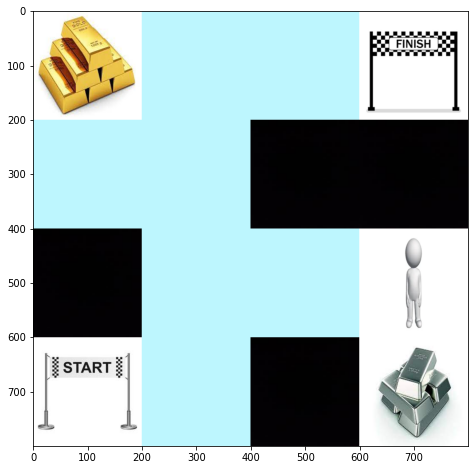

<IPython.core.display.Javascript object>

In [75]:
env = MazeDeterministicEnv()
agent = RandomAgent(env)

state = env.reset()

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()
  clear_output(wait=True)

time.sleep(1)
done = False
while not done:
  action = agent.step(state)
  state, reward, done, info = env.step(action)
  with output_grid.output_to(0, 0):
    clear_output(wait=True)
    env.render()
  time.sleep(1)

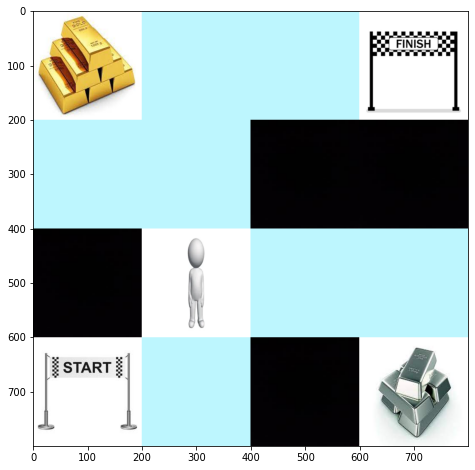

<IPython.core.display.Javascript object>

In [76]:
env = MazeStochasticEnv()
agent = RandomAgent(env)

state = env.reset()

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()
  clear_output(wait=True)

time.sleep(1)
done = False
while not done:
  action = agent.step(state)
  state, reward, done, info = env.step(action)
  with output_grid.output_to(0, 0):
    clear_output(wait=True)
    env.render()
  time.sleep(1)